# Cross-Validation

- Do **k-fold cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

In [ ]:
!pip install category_encoders==2.*

     |████████████████████████████████| 80 kB 4.4 MB/s 


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

In [ ]:
train = pd.merge(pd.read_csv('train_features.csv', na_values=[0,  -2.000000e-08], parse_dates=['date_recorded']),
pd.read_csv('train_labels.csv', na_values=[0, -2.000000e-08]))

In [ ]:
def wrangle(df):
  # Copy in the wrangle function from yesterday as a starting place

  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  #Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns = 'date_recorded', inplace = True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of null values
  df.drop(columns='num_private', inplace=True)
  
  return df

In [ ]:
train = wrangle(train)

train.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,15.0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,NaN
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,NaN
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,14.0


# II. Split Data

## Split Target Variable from Feature Matrix

In [ ]:
target = 'status_group'
y_train = train[target]
X_train = train.drop(columns=target)

# Training-Validation Split

- Since we're doing k-fold CV, there's no need for a validation set.

In [ ]:
cv_scores_dt = cross_val_score(model_dt, X_train, y_train, cv = 5, n_jobs = -1)
cv_scores_rf = cross_val_score(model_rf, X_train, y_train, cv = 5, n_jobs = -1)

In [ ]:
print('Average CV score for decision tree model:', cv_scores_dt.mean()) 
print('Average CV score for decision tree model:', cv_scores_rf.mean()) 

Average CV score for decision tree model: 0.7478114478114477
Average CV score for decision tree model: 0.795959595959596


# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.5429713804713805


# IV. Build Models

- `DecisionTreeClassifier`
- `RandomForestClassifier`

In [ ]:
#Decision Tree Classifier
model_dt = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(),
  DecisionTreeClassifier(random_state=42)    
  )

#Random Forest Classifier
model_rf = make_pipeline(
  OrdinalEncoder(),
  SimpleImputer(),
  RandomForestClassifier(n_estimators=25, random_state=42)    
  )

In [ ]:
#Fit the classifiers
model_dt.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                 

### Train_Test_Split scores (can't be compared to CV scores)

In [ ]:
print('Decision Tree model Train score',model_dt.score(X_train, y_train))
print('Random Forest model Train score',model_rf.score(X_train, y_train))

Decision Tree model Train score 0.9952861952861953
Random Forest model Train score 0.9924873737373737


**Check cross-validation scores**

![Cross Validation](https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif)

In [ ]:
print('CV Score Decision Tree Classifier')
print(cv_scores_dt)
print('Average CV score for decision tree model:', cv_scores_dt.mean()) 
print('Standard Deviation CV score for decision tree model:', cv_scores_dt.std())

CV Score Decision Tree Classifier
[0.74168771 0.75021044 0.74842172 0.75305135 0.74568603]
Average CV score for decision tree model: 0.7478114478114477
Standard Deviation CV score for decision tree model: 0.0038884880344953175


In [ ]:
print('CV Score Random Forest Classifier')
print(cv_scores_rf)
print('Average CV score for random forest model:', cv_scores_rf.mean()) 
print('Standard Deviation CV score for random forest model:', cv_scores_rf.std())


CV Score Random Forest Classifier
[0.79303451 0.79640152 0.79808502 0.80061027 0.79166667]
Average CV score for random forest model: 0.795959595959596
Standard Deviation CV score for random forest model: 0.003265787160701417


# V. Tune Model

- What are important hyperparameters for `RandomForestClassifier`?
  - `max_depth`: 5-35
  - `n_estimators` 25-100
  - imputation strategy

In [ ]:
#depths = range(10,25,1)

#list(depths)

#train_acc = []
#val_acc = []

#for depth in depths:
#  print("current depth", depth)
#  model_dt = make_pipeline(
#    OrdinalEncoder(),
#    SimpleImputer(),
#    RandomForestClassifier(random_state=7, max_depth=depth)
#  )

#  model_dt.fit(X_train, y_train);

#  train_acc.append(accuracy_score(y_train, model_dt.predict(X_train)))
#  val_acc.append(accuracy_score(y_val, model_dt.predict(X_val)))

**`GridSearch`:** Very thourough, but it can take a long time.

Test out every single combination of hyperparameters that we provide it
**and** it's going to use cross-validation.

In [ ]:
paramater_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}


rf_cv_grid = GridSearchCV(
    model_rf,
    param_grid = paramater_grid,
    n_jobs = -1,
    cv =5,
    verbose= 2
)

In [ ]:
rf_cv_grid.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.2s


KeyboardInterrupt: ignored

**`RandomizedSearchCV`:** Quicker, less effective but usually good enough.

In [ ]:
rf_cv_random = RandomizedSearchCV(
    model_rf,
    param_distributions = paramater_grid,
    n_iter = 5,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

In [ ]:
rf_cv_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.3s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['basin',
                                                                   'region',
                                                                   'public_meeting',
                                                                   'scheme_management',
                                                                   'permit',
                                                                   'extraction_type',
                                                                   'extraction_type_group',
                                                                   'extraction_type_class',
                                                                   'management',
                                                                   'management_group',
  

# Make Submission

In [ ]:
X_test = wrangle(pd.read_csv('test_features.csv', parse_dates=['date_recorded']))
predictions = pd.DataFrame(data=rf_cv_random.predict(X_test), index=X_test.index)

predictions.columns = ['status_group']

predictions.insert(0, 'id', predictions.index)

predictions = predictions.reset_index(drop=True)

# generate CSV
predictions.to_csv('sample_submission_Vignesh_rf.csv', index=False)

In [ ]:
# download
from google.colab import files
files.download("sample_submission_Vignesh_rf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VI. Communicate Results

**Showing Feature Importance**

Plot the feature importance for our `RandomForest` model.

Text(0.5, 0, 'Reduction in Gini Impurity')

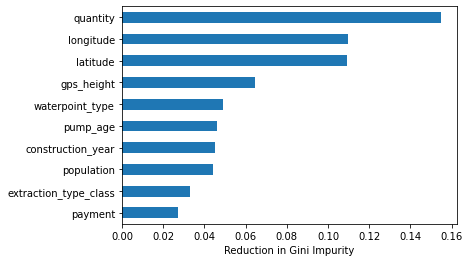

In [ ]:
bestimator = rf_cv_random.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.tail(10).plot(kind = 'barh')
plt.xlabel('Reduction in Gini Impurity')